# Test-Time Augmentation for Tabular Data
> Improving predictive performance during inference

- toc: true
- badges: true
- comments: true
- author: Nikita Kozodoi
- categories: [python, structured data, test-time augmentation]
- image: images/posts/tta_tabular.png

# 1. Overview

Test time augmentation (TTA) is a popular data augmentation technique in computer vision. TTA aims at boosting the predictive performance of a model. The idea behind TTA is to perform random modifications to the test images on the inference stage and average model predictions over multiple versions of the same image.

This blogpost explores the opportunities to use TTA in the structured data environment.

# 2. Implementing TTA

## Defining TTA for tabular data

## How to treat categorical features?

## Implementing TTA with scikit-learn

In [117]:
#collapse-show

def predict_proba_with_tta(data, 
                           model, 
                           dummies = None, 
                           num_tta = 4, 
                           alpha   = 0.01, 
                           beta    = 0.01, 
                           seed    = 0):
    '''
    Predicts class probabilities using TTA.
    
    Arguments:
    - data (numpy array): data set with the feature values 
    - model (sklearn model): machine learning model
    - dummies (list): list of column names of dummy features
    - num_tta (integer): number of test-time augmentations
    - alpha (float): noise parameter for continuous features
    - beta (float): noise parameter for dummy features
    - seed (integer): random seed

    Returns:
    - array of predicted probabilities
    '''
    
    # set random seed
    np.random.seed(seed = seed)
    
    # original prediction
    preds = model.predict_proba(data) / (num_tta + 1)
     
    # select numeric features
    num_vars = [var for var in data.columns if data[var].dtype != 'object']
        
    # find dummies
    if dummies != None:
        num_vars = list(set(num_vars) - set(dummies))
    
    # synthetic predictions
    for i in range(num_tta):
        
        # copy data
        data_new = data.copy()
    
        # introduce noise to numeric vars
        for var in num_vars:
            data_new[var] = data_new[var] + alpha * np.random.normal(0, 1, size = len(data_new)) * data_new[var].std()
            
        # introduce noise to dummies
        if dummies != None:
            for var in dummies:
                probs = np.random.binomial(1, (1 - beta), size = len(data_new))
                data_new.loc[probs == 0, var] = 1 - data_new.loc[probs == 0, var]
            
        # predict probs
        preds_new = model.predict_proba(data_new) 
        preds    += preds_new / (num_tta + 1)
    
    # return probs
    return preds

# 3. Experiments on UCI Data

In [178]:
#collapse-hide

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import os
import time

This function creates multiple versions of the test data by adding noise to numeric variables. Predictions are averaged across all versions of the test data.

Parameters:
- X_test = test data as pandas dataframe
- model = fitted classifier
- dummies = list of dummy variables
- n = number of synthetic datasets to create
- seed = random seed
- alpha = noise level for numeric vars: var_new = var + N(0,1) x alpha x SD(var) 
- beta = noise level for dummies: var_new = var with Prob = (1 - beta);  var_new = (1 - var) with Prob = beta

In [119]:
#collapse-show

# list of datasets
datasets = os.listdir('../data')
datasets

['thomas.csv',
 'german.csv',
 'hmeq.csv',
 'bene2.csv',
 'lendingclub.csv',
 'bene1.csv',
 'cashbus.csv',
 'uk.csv',
 'australian.csv',
 'pakdd.csv',
 'gmsc.csv',
 'paipaidai.csv']

In [120]:
#collapse-show

# classifier
clf = RandomForestClassifier(n_estimators = 500, random_state = 1, n_jobs = 4)

# settings
folds = StratifiedKFold(n_splits     = 5, 
                        shuffle      = True, 
                        random_state = 23)

In [125]:
#collapse-show

# placeholders
auc_change = []

# timer
start = time.time()

# modeling loop
for data in datasets:

    ##### DATA PREPARATION

    # import data
    X = pd.read_csv('../data/' + data)

    # convert target to integer
    X.loc[X.BAD == 'BAD',  'BAD'] = 1
    X.loc[X.BAD == 'GOOD', 'BAD'] = 0

    # extract X and y
    y = X['BAD']
    del X['BAD']

    # create dummies
    X = pd.get_dummies(X, prefix_sep = '_dummy_')

    # data information
    print('-------------------------------------')
    print('Dataset:', data, X.shape)
    print('-------------------------------------')

    
    ##### CROSS-VALIDATION
    
    # create objects
    oof_preds_raw = np.zeros((len(X), y.nunique()))
    oof_preds_tta = np.zeros((len(X), y.nunique()))

    # modeling loop
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):

        # data partitioning
        trn_x, trn_y = X.iloc[trn_], y.iloc[trn_]
        val_x, val_y = X.iloc[val_], y.iloc[val_]

        # train the model
        clf.fit(trn_x, trn_y)
        
        # identify dummies
        dummies = list(X.filter(like = '_dummy_').columns)

        # predictions
        oof_preds_raw[val_, :] =  clf.predict_proba(val_x)
        oof_preds_tta[val_, :] =  predict_proba_with_tta(data    = val_x, 
                                                         model   = clf, 
                                                         dummies = dummies,
                                                         num_tta = 5, 
                                                         alpha   = np.sqrt(len(trn_x)) / 3000,
                                                         beta    = np.sqrt(len(trn_x)) / 30000,
                                                         seed    = 1)

    # print performance
    print('- AUC before TTA = %.6f ' % roc_auc_score(y, oof_preds_raw[:,1]))
    print('- AUC with TTA   = %.6f ' % roc_auc_score(y, oof_preds_tta[:,1]))
    print('-------------------------------------')
    print('')
    
    # save AUC delta
    delta = roc_auc_score(y, oof_preds_tta[:,1]) - roc_auc_score(y, oof_preds_raw[:,1])
    auc_change.append(delta)

# display results
print('-------------------------------------')
print('Finished in %.1f minutes' % ((time.time() - start) / 60))
print('-------------------------------------')
print('TTA improves AUC in %.0f/%.0f cases' % (np.sum(np.array(auc_change) > 0), len(datasets)))
print('Mean AUC change = %.6f' % np.mean(auc_change))
print('-------------------------------------')

-------------------------------------
Dataset: thomas.csv (1225, 28)
-------------------------------------
- AUC before TTA = 0.612322 
- AUC with TTA 1 = 0.612152 
- AUC with TTA 2 = 0.613617 
- AUC with TTA 3 = 0.612190 
-------------------------------------

-------------------------------------
Dataset: german.csv (1000, 61)
-------------------------------------
- AUC before TTA = 0.796233 
- AUC with TTA 1 = 0.796350 
- AUC with TTA 2 = 0.796300 
- AUC with TTA 3 = 0.796300 
-------------------------------------

-------------------------------------
Dataset: hmeq.csv (5960, 20)
-------------------------------------
- AUC before TTA = 0.975995 
- AUC with TTA 1 = 0.977148 
- AUC with TTA 2 = 0.976805 
- AUC with TTA 3 = 0.976000 
-------------------------------------

-------------------------------------
Dataset: bene2.csv (7190, 28)
-------------------------------------
- AUC before TTA = 0.801193 
- AUC with TTA 1 = 0.799689 
- AUC with TTA 2 = 0.799387 
- AUC with TTA 3 = 0.80

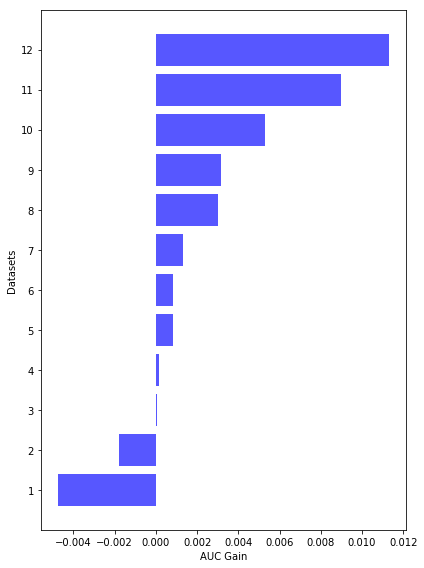

In [172]:
#collapse-hide

objects = list(range(len(datasets)))
y_pos   = np.arange(len(objects))
perf    = np.sort(auc_change2)

plt.figure(figsize = (6, 8))
plt.barh(y_pos, perf, align = 'center', color = 'blue', alpha = 0.66)

plt.ylabel('Dataset')
plt.yticks(y_pos, objects)
plt.xlabel('AUC Gain')
plt.title('')
ax.plot([0, 0], [1, 12], 'k--')
plt.tight_layout()